<a href="https://colab.research.google.com/github/algorithmiaio/model-deployment/blob/master/tensorflow_classify_text_deploy_algorithmia/tensorflow_classify_text_deploy_algorithmia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Classifying Text with Tensorflow & Deploying with Algorithmia

This notebook aims to show how you can deploy a tensorflow model to Algorithmia.
You can also deploy this model from Google Colab! Just click on the "Open in Colab" badge above.

## 1.1 Setup virtual environment & install packages

Setup a virtual environment using Python 3.6 (conda works great)

Pip install the following packages in your environment:

* tensorflow==1.12.2
* algorithmia==1.1.4
* jupyter==1.0.0
* gitpython==2.1.11
* matplotlib==3.0.2
* urllib3==1.24.3
* retry==0.9.2
* numpy==1.16.1
* prompt-toolkit==1.0.16

If the notebook doesn't work with the packages above, please create an issue [here](https://github.com/algorithmiaio/model-deployment/issues).

**(Optional for Google Colab):** Please keep in mind that Google Colab constantly updates their default packages.

Please pip install the following packages if you're on Google Colab:

In [ ]:
!pip install tensorflow==1.12.2 algorithmia==1.1.4 jupyter==1.0.0 gitpython==2.1.11 matplotlib==3.0.2 urllib3==1.24.3 retry==0.9.2 numpy==1.16.1 prompt-toolkit==1.0.16

## 1.2 Setup credentials

Before we can proceed, we need to setup our credentials.

If you haven't already, you can signup on Algorithmia [here](https://algorithmia.com/signup?utm_medium=jupyter-notebook&utm_source=jupyter-notebook).
When creating your API key, make sure to enable `Read & Write` for `Data Access` and enable `Management APIs`.


In [1]:
# Your Algorithmia API key
api_key = "simBhY0vrbZePbcRbHaQ9E3xacr1" # Create an API key with BOTH "Read & Write Data" and "Manage Algorithms": https://algorithmia.com/user#credentials

# Define your username & algorithm name, this will be used later
username = "b"
algoname = "movie_review_sentiment"


## 1.3 Imports for Tensorflow

Let's now import everything we need to download our dataset and train our model:

In [2]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import numpy as np
from retry import retry

print("Installed Tensorflow version: {}".format(tf.__version__))

Installed Tensorflow version: 1.12.0


## 2. Dowload the IMDB dataset

Let's download the IMDB dataset using the keras built-in datasets tool:

In [3]:
imdb = keras.datasets.imdb

print("Downloading the IMDB dataset...")

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

print("Download complete!")

Download complete!


## 3. Explore the data

Let's see how many reviews we have in our dataset:

In [4]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


Let's preview the first entry in the dataset:

In [5]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Before you can start training, you need to make sure all of your reviews are vectorized. Fortunately, our dataset is already vectorized.

Let's also check the vector lengths of the first two reviews:

In [6]:
print("First vector length: {}".format(len(train_data[0])))
print("Second vector length: {}".format(len(train_data[1])))

First vector length: 218
Second vector length: 189


As you can see, they're not fixed-length. This is an issue, as most models can't handle variable-length vectors.

We need to later fix them to a static size.

## 4. Convert the integers back to words

Before we fix the lengths of vectors, let's first confirm that these vectors are indeed movie reviews.

Our dataset comes with a word index. We can use this to decode movie vectors.

Let's write a function called `decode_review(text)` that can decode vectors back into movie reviews.

In [7]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

Now let's check the texrt version of the first review:

In [8]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 5. Prepare the data

Now it's time to create the training & testing datasets.

We're also going to resize our vectors up to 256. We'll add `<PAD>` tokens to fill them up:

In [9]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

Let's now confirm the new vector sizes:

In [10]:
print("First vector length: {}".format(len(train_data[0])))
print("Second vector length: {}".format(len(train_data[1])))

First vector length: 256
Second vector length: 256


Let's also confirm that the first vector has been padded:

In [11]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

As you can see above, the vectors has been padded w/ zeros.

## 6. Build the model

Now we can define our model layers:

In [12]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


Let's select our optimizer, loss function & metric:

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Our model is now ready to train.

## 7. Create a validation set

We need to create a validation dataset that will be used for training:

In [14]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## 8. Train the model

We can now train our model:

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

/Users/besirkurtulmus/Desktop/notebooks/venv3.6/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 42us/step - loss: 0.6917 - acc: 0.5612 - val_loss: 0.6899 - val_acc: 0.5992
Epoch 2/40
15000/15000 [==============================] - 0s 23us/step - loss: 0.6864 - acc: 0.6881 - val_loss: 0.6827 - val_acc: 0.7400
Epoch 3/40
15000/15000 [==============================] - 0s 22us/step - loss: 0.6753 - acc: 0.7575 - val_loss: 0.6686 - val_acc: 0.7519
Epoch 4/40
15000/15000 [==============================] - 0s 21us/step - loss: 0.6548 - acc: 0.7680 - val_loss: 0.6452 - val_acc: 0.7574
Epoch 5/40
15000/15000 [==============================] - 0s 20us/step - loss: 0.6232 - acc: 0.7904 - val_loss: 0.6104 - val_acc: 0.7846
Epoch 6/40
15000/15000 [==============================] - 0s 21us/step - loss: 0.5814 - acc: 0.8079 - val_loss: 0.5691 - val_acc: 0.7998
Epoch 7/40
15000/15000 [==============================] - 0s 22us/step - loss: 0.5335 - acc: 0.8267 - val_loss: 0.5247 - val_acc

## 9. Evaluate the model

Let's now get the loss & accuracy of our model using our test dataset:

In [16]:
results = model.evaluate(test_data, test_labels)

print("Loss: {}, Accuracy: {}".format(results[0], results[1]))

25000/25000 [==============================] - 0s 15us/step
Loss: 0.3287636860847473, Accuracy: 0.87288


## 10. Create a graph of accuracy and loss over time

Let's also visually see the how our model has trained over time.

We'll graph two things:

* Training and validation loss
* Training and validation accuracy

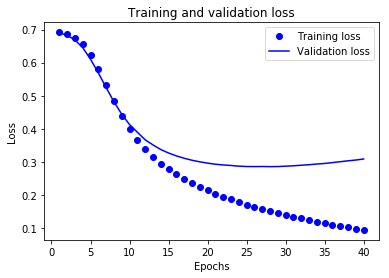

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

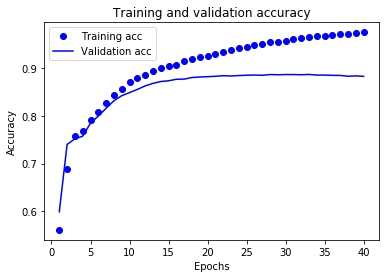

In [18]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 11. Deployment

### Algorithmia credentials

Before we can proceed, we need to setup our Algorithmia client, which will help us deploy our model.

If you haven't already, you can signup on Algorithmia [here](https://algorithmia.com/signup?utm_medium=jupyter-notebook&utm_source=jupyter-notebook).
When creating your API key, make sure to enable `Read & Write` for `Data Access` and enable `Management APIs`.
For more info, see the full [Algorithm Management API Specification](https://docs.algorithmia.com/?python#algorithm-management-api)

In [19]:
import Algorithmia
from Algorithmia.errors import AlgorithmException

# Your Algorithmia API key (already defined at the top of the notebook)
# api_key = "simXXXXXXXXXXXXXXXXXXXXXXXXX" # Create an API key with BOTH "Read & Write Data" and "Manage Algorithms": https://algorithmia.com/user#credentials

# Define your username & algorithm name, this will be used later (already defined at the top of the notebook)
# username = "username"
# algoname = "movie_review_sentiment"

# A data collection, where we'll be storing our files
data_path = "data://.my/mycollection"

# Create a new algorithmia client
client = Algorithmia.client(api_key)

Let's create our data collection on Algorithmia.

In [20]:
# Create data collection if it doesn't exist
if not client.dir(data_path).exists():
    client.dir(data_path).create()

### Create local directory for algorithm files

On Algorithmia, algorithms are git repositories.

This enables local algorithm development.

Before pushing our deployment code, we need a local work directory, so we can git clone our algorithm.

In [21]:
import os
import shutil

# Define local work directory
local_dir = "algo"

# Delete local directory if it already exists
if os.path.exists(local_dir):
    shutil.rmtree(local_dir)

# Create local work directory
os.makedirs(local_dir)

Awesome! We now have a place to store our git repository, related files & code.

### Upload Model File

We can now upload our serialized model file to our newly created data collection.

In [22]:
model_name = "text_classification_model.h5"
local_model = "{}/{}".format(local_dir, model_name)
data_model = "{}/{}".format(data_path, model_name)

# Serialize the model locally
model.save(local_model)

# Upload our model file to our data collection
_ = client.file(data_model).putFile(local_model)

### Upload Word Index

Let's also upload our word index, so we can vectorize movie reviews.

In [23]:
import pickle

word_index_name = "word_index.pickle"
local_word_index = "{}/{}".format(local_dir, word_index_name)
data_word_index = "{}/{}".format(data_path, word_index_name)

# Serialize (pickle) our word index
with open(local_word_index, "wb") as fh:
    pickle.dump(word_index, fh)

# Upload word index file to our data collection
_ = client.file(data_word_index).putFile(local_word_index)

### Create a new algorithm

Using the Algorithmia client, we're going to create a new algorithm.

Let's define the algorithm details and settings.

In [24]:
# Algorithms are refered with the following schema: username/algoname
algo_namespace = "{}/{}".format(username, algoname)

# Here are some details you can define for your algorithm
details = {
        "summary": "This algorithms returns the sentiment of movie reviews.",
        "label": "Movie Review Sentiment Analysis",
        "tagline": "movie_review_sentiment"
}

# 1. We're making our algorithm closed-sourced – "source_visibility"
# 
# 2. We're selecting a package set that has tensorflow-gpu already installed. – "package_set"
#    Even though we could manually install it later, using the optimized
#    & pre-installed image allows you to compile things faster.
# 
# 3. We're selectig the Algorithmia Platform License (aka. "apl"). – "license"
# 
# 4. We're giving our algorithm internet access. – "network_access"
# 
# 5. We're allowing our algorithm to call other algorithms. – "pipeline_enabled"
settings = {
        "source_visibility": "closed",
        "package_set": "tensorflow-gpu-1.12",
        "license": "apl",
        "network_access": "full",
        "pipeline_enabled": True
}

print("Algorithm namepace: {}".format(algo_namespace))

Algorithm namepace: b/movie_review_sentiment


Let's now create an algorithm with the details & settings provided above.

In [25]:
# Create a new algorithm
client.algo(algo_namespace).create(details, settings)

{'details': {'label': 'Movie Review Sentiment Analysis',
             'summary': 'This algorithms returns the sentiment of movie '
                        'reviews.',
             'tagline': 'movie_review_sentiment'},
 'name': 'movie_review_sentiment',
 'self_link': None,
 'settings': {'algorithm_callability': 'private',
              'environment': None,
              'language': None,
              'license': 'apl',
              'network_access': 'full',
              'package_set': 'tensorflow-gpu-1.12',
              'pipeline_enabled': True,
              'royalty_microcredits': None,
              'source_visibility': 'closed'}}

In [26]:
# Print the URL to the algorithm
print("Algorithm URL: https://algorithmia.com/algorithms/{}".format(algo_namespace))

Algorithm URL: https://algorithmia.com/algorithms/b/movie_review_sentiment


Voila! Our algorithm now exists!

We can now start working on our code.

### Git clone our algorithm locally

Now it's time to git clone our algorithm.

In [27]:
import urllib.parse
from git import Git, Repo, remote

# Encode API key, so we can use it in the git URL
encoded_api_key= urllib.parse.quote_plus(api_key)

algo_repo = "https://{}:{}@git.algorithmia.com/git/{}/{}.git".format(username, encoded_api_key, username, algoname)

class Progress(remote.RemoteProgress):
    def line_dropped(self, line):
        print(line)
    def update(self, *args):
        print(self._cur_line)

p = Progress()

_ = Repo.clone_from(algo_repo, "{}/{}".format(local_dir, algoname), progress=p)

cloned_repo = Repo("{}/{}".format(local_dir, algoname))

Cloning into 'algo/movie_review_sentiment'...
POST git-upload-pack (157 bytes)
remote: Counting objects: 1
remote: Counting objects: 7, done
remote: Finding sources:  14% (1/7)
remote: Finding sources:  28% (2/7)
remote: Finding sources:  42% (3/7)
remote: Finding sources:  57% (4/7)
remote: Finding sources:  71% (5/7)
remote: Finding sources:  85% (6/7)
remote: Finding sources: 100% (7/7)
remote: Finding sources: 100% (7/7)
remote: Getting sizes:  16% (1/6)
remote: Getting sizes:  33% (2/6)
remote: Getting sizes:  50% (3/6)
remote: Getting sizes:  66% (4/6)
remote: Getting sizes:  83% (5/6)
remote: Getting sizes: 100% (6/6)
remote: Getting sizes: 100% (6/6)
remote: Total 7 (delta 0), reused 7 (delta 0)


### Algorithm Code Structure

The algorithm repo structure looks something like this:

* `<algoname>`/
    * src/
        * `<algoname>`.py
        * `<algoname>`_test.py
    * algorithmia.conf
    * requirements.txt

We're only interested in two files: `<algoname>`.py & requirements.txt

In [28]:
algo_script_path = "{}/{}/src/{}.py".format(local_dir, algoname, algoname)
dependency_file_path = "{}/{}/{}".format(local_dir, algoname, "requirements.txt")

### Algorithm Script
We now want to change the default script with our inference script.

There's only four things you need to keep in mind:

* Import your libraries. (algorithmia included)
* Download & load your model
* Put all of your inference code under the `apply()` function.
* Make sure to return a python primitive. (eg. string, list, dicts, or combinations of three)

In [29]:
%%writefile $algo_script_path
import Algorithmia
from tensorflow import keras
import numpy as np
import pickle

# Create our Algorithmia client
client = Algorithmia.client()

# Define where our files live in our data collection
data_model = "data://.my/mycollection/text_classification_model.h5"
data_word_index = "data://.my/mycollection/word_index.pickle"

# Download & initialize our model
model_file = client.file(data_model).getFile().name
model = keras.models.load_model(model_file)

# Download & initialize our word index
word_index_file = client.file(data_word_index).getFile().name
with open(word_index_file, "rb") as fh:
    word_index = pickle.load(fh)

# Function for vectorizing our input text
def vectorize_text(text):
    vector = []
    words = text.split(" ")
    for word in words:
        if word in word_index:
            vector.append(word_index[word])
    
    return keras.preprocessing.sequence.pad_sequences([np.array(vector, dtype=np.int32)],
                                               value=word_index["<PAD>"],
                                               padding='post',
                                               maxlen=256)

def apply(input):
    # Get input text
    input_text = input["text"]
    # Vectorize input text
    input_vector = vectorize_text(input_text)
    # Get probability using our model
    prob = float(model.predict(input_vector)[0][0])
    # Return result back to user
    return {"prob": prob}

Overwriting algo/movie_review_sentiment/src/movie_review_sentiment.py


### Algorithm dependency file

Let's also define the package our algorithm depends on.

In [30]:
%%writefile $dependency_file_path
algorithmia>=1.0.0,<2.0
six
tensorflow-gpu==1.12.0

Overwriting algo/movie_review_sentiment/requirements.txt


### Upload our source code

We can now git add, commit and push our code to Algorithmia.

In [31]:
files = ["src/{}.py".format(algoname), "requirements.txt"]
cloned_repo.index.add(files)

[(100644, a4095d6503460be5775a598399180c2648b9ddf8, 0, src/movie_review_sentiment.py),
 (100644, 0dc1fbffb5932db7e33d30a28626629d3cb9953b, 0, requirements.txt)]

In [32]:
cloned_repo.index.commit("Add algorithm files")

<git.Commit "696dffab302b48281ebc0d6f43da672bf0b935d3">

In [33]:
origin = cloned_repo.remote(name='origin')
origin.push(progress=p)

Enumerating objects: 9, done.
Counting objects:  11% (1/9)
Counting objects:  22% (2/9)
Counting objects:  33% (3/9)
Counting objects:  44% (4/9)
Counting objects:  55% (5/9)
Counting objects:  66% (6/9)
Counting objects:  77% (7/9)
Counting objects:  88% (8/9)
Counting objects: 100% (9/9)
Counting objects: 100% (9/9), done.
Delta compression using up to 8 threads
Compressing objects:  20% (1/5)
Compressing objects:  40% (2/5)
Compressing objects:  60% (3/5)
Compressing objects:  80% (4/5)
Compressing objects: 100% (5/5)
Compressing objects: 100% (5/5), done.
Writing objects:  20% (1/5)
Writing objects:  40% (2/5)
Writing objects:  60% (3/5)
Writing objects:  80% (4/5)
Writing objects: 100% (5/5)
Writing objects: 100% (5/5), 1.04 KiB | 1.04 MiB/s, done.
Total 5 (delta 0), reused 0 (delta 0)
remote: Updating references: 100% (1/1)
remote: Updating references: 100% (1/1)
remote:
remote: Build successful for algo://b/movie_review_sentiment/696dffab302b48281ebc0d6f43da672bf0b935d3
remote:


When we successfully git push, it means that the algorithm has also been compiled.

In [34]:
# Print the URL to the algorithm source code
print("Algorithm Source Code URL: https://algorithmia.com/algorithms/{}/source".format(algo_namespace))

Algorithm Source Code URL: https://algorithmia.com/algorithms/b/movie_review_sentiment/source


### Call & test our algorithm

To be able to call & test our algorithm, we need to latest hash version:

In [ ]:
latest_hash = client.algo(algo_namespace).info().version_info.git_hash

Let's also define our function for calling our API endpoint

In [ ]:
# Call algorithm until the algo hash endpoint becomes available, up to 10 seconds
@retry(AlgorithmException, tries=10, delay=1)
def get_probability(ALGO, VERSION, INPUT):
    return client.algo("{}/{}".format(ALGO, VERSION)).pipe(INPUT).result["prob"]

Let's now call our new API endpoint with the latest hash:

In [ ]:
algo_input = {
    "text": "This is a very positive review for the movie. I absolutely loved it!"
}

# Call the algorithm endpoint with the latest hash
prob = get_probability(algo_namespace, latest_hash, algo_input)

print("Probability for test is: {}".format(prob))

We just called our model that was deployed behind a infinitely scalable API endpoint.

Once we're happy with our algoritm, we can go ahead and publish it:

In [ ]:
# Now let's publish/deploy our algorithm
client.algo(algo_namespace).publish()

Let's get the latest published semantic version:

In [ ]:
latest_version = client.algo(algo_namespace).info().version_info.semantic_version

We can now call this published endpoint too:

In [ ]:
# Call the algorithm endpoint with the latest version
prob = get_probability(algo_namespace, latest_version, algo_input)

print("Probability for test is: {}".format(prob))

You just successfully deployed your Tensorflow model!

You can call this API endpoint from anywhere: your mobile app, your website, and more...

### License

This notebook is based on the guide from: https://www.tensorflow.org/tutorials/keras/basic_text_classification

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.